In [62]:
from rmatrix import Particle, ElasticChannel, CaptureChannel, SpinGroup
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

## using the rmatrix package

The particles need to be defined first:

In [63]:
help(Particle)

Help on class Particle in module rmatrix.base.particles:

class Particle(builtins.object)
 |  Particle(label, A, Z, Sn=0)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, label, A, Z, Sn=0)
 |      Class to hold information about a particle/isotope
 |      
 |      Parameters
 |      ----------
 |      label : str
 |          string label for the particle
 |      
 |      A : int
 |          Mass number
 |      
 |      Z : int
 |          Z of the particle
 |      
 |      Sn : float, optional, default: 0
 |          Neutron separation energy in eV, if applicable
 |      
 |      Attributes
 |      ----------
 |      label : str
 |          string label for the particle
 |      
 |      A : int
 |          Mass number
 |      
 |      Z : int
 |          Z of the particle
 |      
 |      Sn : float, optional, default: 0
 |          Neutron separation energy in eV, if applicable
 |      
 |      Methods
 |      -------
 |      No methods are currently defined
 |  
 |  __repr__(s

In [64]:
neutron = Particle('n',1,0)
gamma = Particle('g',0,0)

target = Particle("181Ta",181,73)
compound = Particle("182Ta", 182,73, Sn=6.6e6)

A single elastic and two capture channels are defined

In [65]:
help(ElasticChannel)

Help on class ElasticChannel in module rmatrix.channels.elastic_channel:

class ElasticChannel(rmatrix.channels.abstract_channel.AbstractChannel)
 |  ElasticChannel(neutron, target, J, pi, ell, ac, reduced_width_amplitudes=None, partial_widths=None, resonance_energies=None)
 |  
 |  Method resolution order:
 |      ElasticChannel
 |      rmatrix.channels.abstract_channel.AbstractChannel
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, neutron, target, J, pi, ell, ac, reduced_width_amplitudes=None, partial_widths=None, resonance_energies=None)
 |      Class representing an elastic channel
 |      
 |      If reduced_width_amplitudes are not given, both partial_widths
 |      and resonance_energies must be given so that the reduced width
 |      amplitudes can be calculated. 
 |      
 |      If both reduced_width_amplitudes and partial_widths are given,
 |      reduced_width_amplitudes will be used and partial_widths will 
 |      be ignored

In [66]:
J = 3
pi = 1  # positive parity
ell = 0  # only s-waves are implemented right now
radius = 0.2   # *10^(-12) cm 
reduced_width_amplitudes = [106.78913185, 108.99600881]

elastic = ElasticChannel(neutron, target,J,pi,ell,radius,reduced_width_amplitudes)

A capture channel to the ground state of the product nucleus is defined:

In [67]:
help(CaptureChannel)

Help on class CaptureChannel in module rmatrix.channels.capture_channel:

class CaptureChannel(rmatrix.channels.abstract_channel.AbstractChannel)
 |  CaptureChannel(primary, product, J, pi, ell, ac, excitation, reduced_width_amplitudes=None, partial_widths=None, resonance_energies=None)
 |  
 |  Method resolution order:
 |      CaptureChannel
 |      rmatrix.channels.abstract_channel.AbstractChannel
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, primary, product, J, pi, ell, ac, excitation, reduced_width_amplitudes=None, partial_widths=None, resonance_energies=None)
 |      Class representing a capture channel
 |      
 |      If reduced_width_amplitudes are not given, both partial_widths
 |      and resonance_energies must be given so that the reduced width
 |      amplitudes can be calculated. 
 |      
 |      If both reduced_width_amplitudes and partial_widths are given,
 |      reduced_width_amplitudes will be used and partial_widths

In [68]:
J = 3
pi = 1  # positive parity
ell = 1 # orbital ang. momentum of the outgoing primary gamma
radius = 0.2   # *10^(-12) cm 
reduced_width_amplitudes = [2.51487027e-06, 2.49890268e-06]
excitation = 0  # the product is left in the ground state 

capture_ground = CaptureChannel(gamma,compound,J,pi,ell,radius,excitation,reduced_width_amplitudes)

and a capture channel to the 1st excited state, at 0.5 MeV, is defined (for this simple example, the widths are just scaled from the ground state channel):

In [69]:
J = 3
pi = 1  # positive parity
ell = 2 # orbital ang. momentum of the outgoing primary gamma
radius = 0.2   # *10^(-12) cm 
reduced_width_amplitudes = 0.8*capture_ground.reduced_width_amplitudes
excitation = 5e5  # the product is left in the 1st ex state at 0.5MeV

capture_first = CaptureChannel(gamma,compound,J,pi,ell,radius,excitation,reduced_width_amplitudes)

the representation of the channel objects is the reaction:

In [70]:
str(capture_first)

'g + 182Ta(0.5 MeV)'

In [71]:
elastic

## set up Spin Group object

In [72]:
res_energies = [1e6,1.1e6]
energy_grid = np.linspace(0.9e6,1.2e6,1001)

sg = SpinGroup(res_energies, elastic, [capture_ground, capture_first],energy_grid)

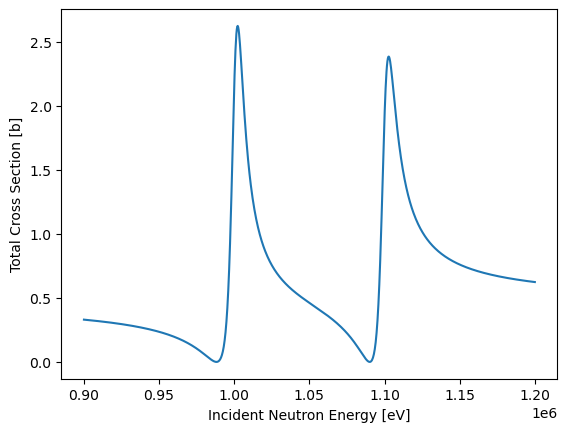

In [73]:
plt.plot(sg.energy_grid, sg.total_cross_section)
plt.ylabel("Total Cross Section [b]")
plt.xlabel("Incident Neutron Energy [eV]")
plt.savefig("three_channel_total_example.png")

Text(0.5, 0, 'Incident Neutron Energy [eV]')

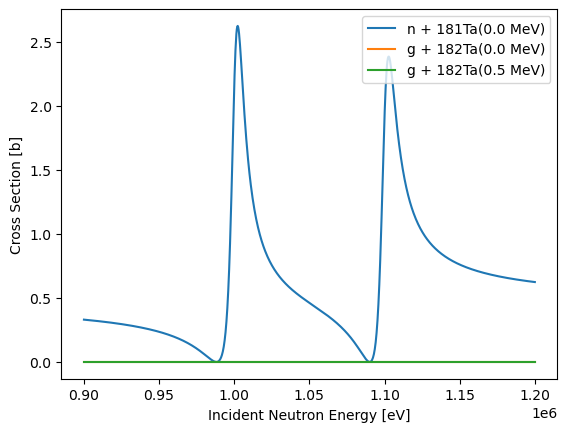

In [74]:
for channel in sg.channels:
    plt.plot(sg.energy_grid, channel.cross_section, label=channel)

plt.legend()
plt.ylabel("Cross Section [b]")
plt.xlabel("Incident Neutron Energy [eV]")

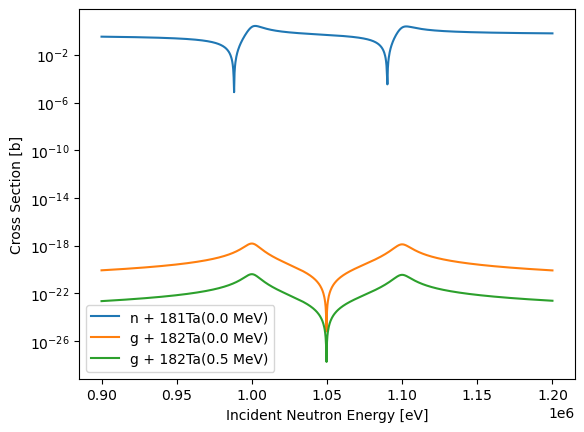

In [75]:
for channel in sg.channels:
    plt.plot(sg.energy_grid, channel.cross_section, label=channel)

plt.yscale("log")
plt.legend()
plt.ylabel("Cross Section [b]")
plt.xlabel("Incident Neutron Energy [eV]")
plt.savefig("three_channel_example.png")

## modify the gamma matrix

once the spin group object has been created, the gamma matrix can be manually changed using the `update_gamma_matrix()` method. it will update the rest of the matrices and calculate new cross sections

In [76]:
new_sg = deepcopy(sg)

new_gamma_matrix = 0.5 * sg.gamma_matrix

new_sg.update_gamma_matrix(new_gamma_matrix)

Text(0.5, 0, 'Incident Neutron Energy [eV]')

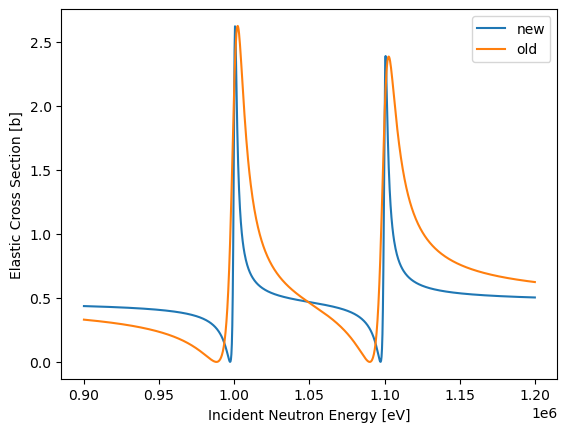

In [77]:
plt.plot(new_sg.energy_grid, new_sg.channels[0].cross_section, label="new")
plt.plot(sg.energy_grid, sg.channels[0].cross_section, label="old")


plt.legend()
plt.ylabel("Elastic Cross Section [b]")
plt.xlabel("Incident Neutron Energy [eV]")

Text(0.5, 0, 'Incident Neutron Energy [eV]')

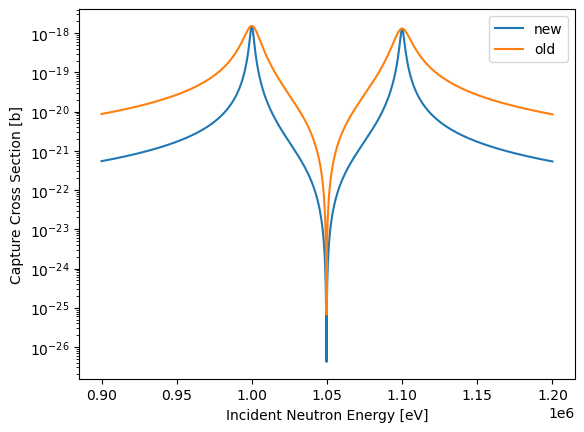

In [78]:
plt.plot(new_sg.energy_grid, new_sg.channels[1].cross_section, label="new")
plt.plot(sg.energy_grid, sg.channels[1].cross_section, label="old")

plt.yscale("log")
plt.legend()
plt.ylabel("Capture Cross Section [b]")
plt.xlabel("Incident Neutron Energy [eV]")